In [35]:
import re
import pandas as pd
import numpy as np
from math import sqrt
from datetime import date
import time

import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
#nltk.download('stopwords')

# Pacotes utilizados para a modelagem
from unicodedata import normalize
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from scipy.stats import norm
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score 

%matplotlib inline

In [36]:
#base = pd.read_csv('features-training-0013.csv')
#target = pd.read_csv('target-training-0013.csv')
#renda = pd.read_excel('renda_per_capita.xlsx')
#base_price = base.merge(target, how='left', on = 'id')
base = pd.DataFrame()
for i in range(10,40):
    base = pd.concat([base, pd.read_csv('features-training/features-training-00'+str(i)+'.csv')],axis=0)
    
target = pd.DataFrame()
for i in range(10,40):
    target = pd.concat([target, pd.read_csv('target-training/target-training-00'+str(i)+'.csv')],axis=0)

renda = pd.read_excel('renda_per_capita.xlsx')
base_price = base.merge(target, how='left', on = 'id')    


In [91]:
def extract_suites(dataframe):
    dataframe2 = dataframe.copy()
    dataframe2.description = dataframe2.description.apply(lambda x: normalize('NFKD', x).encode('ASCII','ignore').decode('ASCII')) #remove acento
    dataframe2.description = dataframe2.description.str.replace('[^0-9a-zA-Z]', ' ').str.lower()
    dataframe2.description = dataframe2.description.str.replace(' +', ' ')
    dataframe2 = dataframe2[dataframe2.description.str.find('suite')>0]
    dataframe2['inicio'] = dataframe2.description.str.find('suite')
    dataframe2['suites'] = dataframe2.apply(lambda x: x['description'][x['inicio']-2:x['inicio']-1], axis=1)
    dataframe2 = dataframe2[dataframe2.suites.isin(['1', '2', '3', '4', '5', '6'])]
    dataframe2.suites = dataframe2.suites.astype(float)

    dataframe = dataframe.merge(dataframe2[['property_id','suites']], how='left', on = 'property_id')
    dataframe.suites = dataframe.suites.fillna(1)
    return dataframe
    

def extract_vagas(dataframe):
    dataframe2 = dataframe.copy()
    dataframe2.description = dataframe2.description.apply(lambda x: normalize('NFKD', x).encode('ASCII','ignore').decode('ASCII')) #remove acento
    dataframe2.description = dataframe2.description.str.replace('[^0-9a-zA-Z]', ' ').str.lower()
    dataframe2.description = dataframe2.description.str.replace(' +', ' ')

    #verifica se aparece o numero de vagas no formato "x vagas"
    dataframe_vaga = dataframe2[dataframe2.description.str.find('vaga')>0].copy()
    dataframe_vaga['inicio1'] = dataframe_vaga.description.str.find('vaga')
    dataframe_vaga['vagas1'] = dataframe_vaga.apply(lambda x: x['description'][x['inicio1']-2:x['inicio1']-1], axis=1)
    dataframe_vaga = dataframe_vaga[dataframe_vaga.vagas1.isin(['1', '2', '3', '4', '5', '6'])]

    #verifica se aparece o numero de vagas no formato "x carros"
    dataframe_carro = dataframe2[dataframe2.description.str.find('carro')>0].copy()
    dataframe_carro['inicio2'] = dataframe_carro.description.str.find('carro')
    dataframe_carro['vagas2'] = dataframe_carro.apply(lambda x: x['description'][x['inicio2']-2:x['inicio2']-1], axis=1)
    dataframe_carro = dataframe_carro[dataframe_carro.vagas2.isin(['1', '2', '3', '4', '5', '6'])]

    dataframe = dataframe.merge(dataframe_vaga[['property_id','vagas1']], how='left', on = 'property_id')
    dataframe = dataframe.merge(dataframe_carro[['property_id','vagas2']], how='left', on = 'property_id')

    dataframe['vagas'] = np.where(dataframe.vagas2.isnull(), dataframe.vagas1, dataframe.vagas2)
    dataframe['vagas'] = dataframe.vagas.fillna(1)   #preenche NA com 1 vaga
    dataframe['vagas'] = dataframe.vagas.astype(float)

    dataframe.drop(['vagas1', 'vagas2'], inplace=True, axis=1)
    return dataframe

#verifica se imóvel possui piscina. 2430 imoveis tem piscina
def extract_piscina(dataframe):
    dataframe2 = dataframe.copy()
    dataframe2.description = dataframe2.description.apply(lambda x: normalize('NFKD', x).encode('ASCII','ignore').decode('ASCII')) #remove acento
    dataframe2.description = dataframe2.description.str.replace('[^0-9a-zA-Z]', ' ')
    dataframe2.description = dataframe2.description.str.replace(' +', ' ').str.lower()
    dataframe['piscina'] = np.where(dataframe2.description.str.find('piscina')>0, 1, 0)
    return dataframe


# extrai o número de quartos da coluna description
def extract_rooms(dataframe):
    
    quarto_null = dataframe.copy()
    quarto_null.description = quarto_null.description.apply(lambda x: normalize('NFKD', x).encode('ASCII','ignore').decode('ASCII')) #remove acento
    quarto_null.description = quarto_null.description.str.replace('[^0-9a-zA-Z]', ' ') #deixa só numero e letra
    quarto_null.description = quarto_null.description.str.replace(' +', ' ')
    quarto_null.description = quarto_null.description.str.lower().str.replace('dormitorio|dormitório|dormitrio|dorm', 'quarto')
    quarto_null = quarto_null[quarto_null.description.str.find('quarto')>0]
    quarto_null['inicio'] = quarto_null.description.str.lower().str.find('quarto')
    quarto_null['rooms'] = quarto_null.apply(lambda x: x['description'][x['inicio']-2:x['inicio']-1], axis=1)
    quarto_null = quarto_null[quarto_null.rooms.isin(['1', '2', '3', '4', '5', '6'])]
    quarto_null.rooms = quarto_null.rooms.astype(float)
    dataframe = dataframe.merge(quarto_null[['property_id','rooms']], how='left', on = 'property_id')
    dataframe.rooms_x = np.where(dataframe.rooms_y.isnull(), dataframe.rooms_x, dataframe.rooms_y)
    dataframe.rename(columns = {'rooms_x': 'rooms'}, inplace = True) 
    dataframe.drop(['rooms_y'], inplace=True, axis=1)
    for i in dataframe.property_type.unique():
        y = dataframe.rooms[dataframe.property_type==i]
        dataframe['rooms'] = np.where((dataframe.rooms.isnull()) & (dataframe.property_type==i), y.median(), dataframe.rooms)
        dataframe['rooms'] = np.where((dataframe.rooms > 6) & (dataframe.property_type==i), y.median(), dataframe.rooms)
    dataframe['rooms'] = np.where((dataframe.property_type=='store'), 0, dataframe.rooms) #atribui 0 para quando é store
   
    return dataframe

## Agrupar o tratamento da base dentro de uma função

def process_base(dataframe):
  
    dataframe = dataframe.drop(dataframe[(dataframe['price'] > 2700000)].index) # remove outliers da coluna 'price'
    dataframe = dataframe.drop(dataframe[(dataframe['price'] < 60000)].index) # remove outliers da coluna 'price'
    dataframe = dataframe[dataframe.currency=='BRL'].copy()
    dataframe['city_name'] = dataframe['place_with_parent_names'].str.split("|", n = 4, expand = True)[3]
    columns = ['operation', 'geonames_id', 'lat_lon', 'image_thumbnail', 'floor', 'currency', 'country_name', 'id', 'collected_on', 'place_with_parent_names', 'lat', 'lon', 'surface_total_in_m2', 'expenses' ]
    dataframe.drop(columns, inplace=True, axis=1)
    dataframe = dataframe.drop_duplicates('property_id', keep = 'last')
    dataframe.created_on = pd.to_datetime(dataframe.created_on, format="%Y-%m-%d") #formata data
    dataframe = extract_rooms(dataframe) #extrai nº de quartos
    dataframe = extract_piscina(dataframe) #tem ou não piscina
    dataframe = extract_vagas(dataframe)
    dataframe = extract_suites(dataframe)
    for i in dataframe.property_type.unique():
        y = dataframe.surface_covered_in_m2[dataframe.property_type==i]
        dataframe['surface_covered_in_m2'] = np.where((dataframe.surface_covered_in_m2 > y.quantile(q=0.75)) & (dataframe.property_type==i), y.median(), dataframe.surface_covered_in_m2)
        dataframe['surface_covered_in_m2'] = np.where((dataframe.surface_covered_in_m2 < 1.0) & (dataframe.property_type==i), y.mode(), dataframe.surface_covered_in_m2)
        dataframe['surface_covered_in_m2'] = np.where((dataframe.surface_covered_in_m2.isnull()) & (dataframe.property_type==i), y.median(), dataframe.surface_covered_in_m2)
    
    return dataframe
  

In [92]:
start_time = time.time()
base_limpa = process_base(base_price)
print('Elapsed time: ', (time.time() - start_time)/60, 'minutos')

Elapsed time:  1.426724374294281 minutos


In [93]:
base_limpa = base_limpa.merge(renda[['Cidade', 'Renda', 'Estado']], how='left', left_on = ['city_name', 'state_name'], right_on=['Cidade', 'Estado'])
base_limpa.Renda = base_limpa.Renda.fillna(base_limpa.Renda.mean())

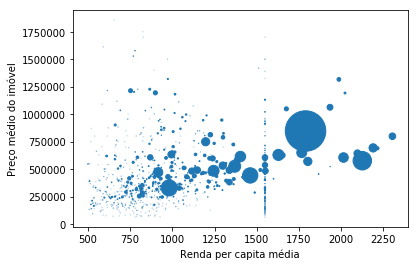

In [94]:
df_corr = base_limpa[['city_name', 'state_name','Renda', 'price']]
df_corr = df_corr.groupby('city_name').agg({'Renda':['mean', 'count'], 'price': ['mean']})
df_corr.columns = df_corr.columns.droplevel(0)
df_corr.columns = ['media_renda', 'qtdd', 'media_price']
df_corr = df_corr[~df_corr.media_renda.isnull()]
df_corr = df_corr[df_corr.media_price<2000000]
plt.scatter(df_corr.media_renda, df_corr.media_price, s=df_corr.qtdd/50)
plt.xlabel('Renda per capita média')
plt.ylabel('Preço médio do imóvel')
plt.show()

In [41]:
pd.set_option('display.max_colwidth', -1) #mostrar todo o conteudo do dataframe (util p/ campo descrição)
#pd.set_option('display.max_colwidth', -1) #default

#  Árvore de Regressão

In [ ]:
base_limpa

In [ ]:
#processamento nos dados para transformar variavel categorica em numerica
dados = pd.get_dummies(base_limpa[['property_type', 'surface_covered_in_m2', 'rooms', 'vagas', 'piscina', 'suites', 'Renda']])

resultados = base_limpa.price
Xtrain, Xtest, Ytrain, Ytest = train_test_split(dados, resultados) # 75% para treino e 25% para teste

In [ ]:
model = tree.DecisionTreeRegressor()
# Treina o modelo usando os dados de treino e de teste confere o score
model.fit(Xtrain, Ytrain)
model.score(Xtrain, Ytrain)

In [ ]:
#Prevê o resultado
predicted= model.predict(Xtest)

In [ ]:
df_new = Xtest.copy()
df_new['price'] = Ytest 
df_new['price_pred'] = predicted
df_new.price_pred = df_new.price_pred.astype(int)

In [ ]:
df_new

# K-Nearest-Neighbors (KNN)

In [ ]:
df = pd.get_dummies(base_limpa[['property_type', 'surface_covered_in_m2', 'rooms', 'vagas', 'piscina', 'suites', 'Renda', 'price']])
#df = base_limpa[['surface_covered_in_m2', 'rooms', 'vagas', 'piscina', 'suites', 'Renda', 'price']]

df.head()

In [ ]:
plt.scatter(x = base_limpa.surface_covered_in_m2, y = base_limpa.price)
plt.ylabel('Preço', fontsize=14)
plt.xlabel('Área', fontsize=14)

In [ ]:
y = base_limpa.price
sns.distplot(y,rug=True)

In [ ]:
y_log = np.log1p(y)

sns.distplot(y_log,fit=norm);
(mu,sigma) = norm.fit(y_log)

In [ ]:
corrmat = df.corr()

plt.figure(figsize = (12,10));

# Generate a mask for the upper triangle
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(230, 10, as_cmap=True)

sns.heatmap(corrmat, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, annot = True);

In [ ]:
train , test = train_test_split(df, test_size = 0.30, random_state = 42)

x_train = train.drop('price', axis=1)
y_train = train['price']

x_test = test.drop('price', axis = 1)
y_test = test['price']

In [ ]:
# Pré-processamento: reescalando as features

scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled, index=x_train.index, columns=x_train.columns)

x_test_scaled = scaler.transform(x_test)
x_test = pd.DataFrame(x_test_scaled, index=x_test.index, columns=x_test.columns)

#sc_x = StandardScaler()
#x_train = sc_x.fit_transform(x_train)
#x_test = sc_x.transform(x_test)

In [ ]:
rmse_val = [] # armazena os valores de rmse para diferentes k's
for K in range(2,31):
    
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)  # ajuste do modelo
    pred=model.predict(x_test) # realiza a predição sobre o conjunto de teste
    error = sqrt(mean_squared_error(y_test,pred)) # calcula o erro - rmse
    rmse_val.append(error)
    print('RMSE para k = ' , K , ':', error)

In [ ]:
# Gráfico dos valores do rmse em função dos valores de K
curve = pd.DataFrame(rmse_val) 
curve.plot()

In [ ]:
params = {'n_neighbors':[8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=6)
model.fit(x_train,y_train)
model.best_params_

In [ ]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 14)

knn.fit(x_train, y_train)  # ajuste do modelo
y_pred = knn.predict(x_test) # realiza a predição sobre o conjunto de teste
error = sqrt(mean_squared_error(y_test,y_pred)) # calcula o erro - rmse
error

In [ ]:
r_squared = r2_score(y_test, y_pred)
adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-x_test_scaled.shape[1]-1)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

print('adjusted r2',adjusted_r_squared)
print('r2',r_squared)
print('MAE', MAE)
print('MSE', MSE)
print('explained variance', explained_variance)

In [ ]:
df_new = x_test
df_new['price'] = y_test 
df_new['price_pred'] = y_pred
df_new['error'] = (abs(y_test - y_pred) / y_test)*100
df_new.price_pred = df_new.price_pred.astype(int)
df_new.head()

In [ ]:
df_new[df_new.error > 50].property_type_apartment.sum()

In [ ]:
df_new[df_new.error < 50]

In [ ]:
df_new.error.describe()

# SVR (Support Vector Regression)

In [77]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import time
from sklearn.metrics import mean_squared_log_error

In [78]:
base_limpa.head(n=1)

,property_id,created_on,property_type,place_name,state_name,surface_covered_in_m2,rooms,description,title,price,city_name,piscina,vagas,suites,Cidade,Renda,Estado
0,fe0e7a187887cbc7241db2ae7e741e6449a7d375,2017-09-28,apartment,Camaquã,Rio Grande do Sul,76.0,2.0,"Um empreendimento cercado pela natureza. Ao planejar este empreendimento, os arquitetos buscaram harmonizar o projeto à natureza exuberante do terreno e tendo um valor acessível como a essência inspiradora de tudo. Foi criado um lugar que dê vontade de viver ao ar livre e receber pessoas queridas. Além de estar localizado em uma rua tranquila, está próximo de uma das melhores escolas, bancos, ótimos restaurantes, supermercados e da importante Avenida Otto Niemeyer. Definitivamente, a Zona Sul está ganhando um empreendimento que alia qualidade de projeto e construção com o melhor preço benefício da região.","Apartamento com 3 quartos e 2 Vagas, Porto Alegre, Camaquã, por R$ 476.603",476603.0,Porto Alegre,0,1.0,1.0,Porto Alegre,2125.19,Rio Grande do Sul


In [117]:
#processamento nos dados para transformar variavel categorica em numerica
dados_svr = pd.get_dummies(base_limpa[['property_type', 'surface_covered_in_m2', 'rooms', 'vagas', 'piscina', 'suites', 'Renda']])
#dados_svr = base_limpa[['property_id','created_on','property_type','place_name','state_name','surface_covered_in_m2','rooms','description','title','city_name','piscina','vagas','suites','Cidade','Renda']]
resultados_svr = base_limpa.price
Xtrain_svr, Xtest_svr, Ytrain_svr, Ytest_svr= train_test_split(dados_svr, resultados_svr, test_size = 0.30) # 75% para treino e 25% para teste

In [118]:
Xtrain_svr

,surface_covered_in_m2,rooms,vagas,piscina,suites,Renda,property_type_PH,property_type_apartment,property_type_house,property_type_store
259401,49.0,2.0,1.0,0,1.0,1551.20,0,1,0,0
68679,163.0,3.0,2.0,1,1.0,2013.83,0,0,1,0
54089,78.0,3.0,1.0,0,1.0,1789.02,0,1,0,0
99406,162.0,3.0,1.0,0,1.0,1244.55,0,0,1,0
155911,85.0,3.0,1.0,0,1.0,1789.02,0,1,0,0
104264,130.0,3.0,3.0,0,1.0,1338.01,0,0,1,0
38976,163.0,4.0,1.0,0,3.0,1675.33,0,0,1,0
127113,163.0,3.0,1.0,0,1.0,1369.48,0,0,1,0
255200,163.0,1.0,2.0,1,3.0,1784.44,0,0,1,0
1726,51.0,2.0,1.0,1,1.0,1238.84,0,1,0,0


In [ ]:
#dados_svr.info()#[['surface_covered_in_m2','rooms','vagas','piscina','suites','Renda']]
dados_svr.head(n=2)

In [ ]:
#svr = SVR()
#g_svr = GridSearchCV(svr,cv=5,n_jobs=8 ,param_grid={"C": [1e0, 1e1, 1e2, 1e3],
#                   "gamma": np.logspace(-2, 2, 5),
#                   "kernel": ["rbf", "linear","sigmoid"]})

In [ ]:
#g_svr.fit(Xtrain_svr, Ytrain_svr)

In [ ]:
#g_svr.best_params_

In [ ]:
start_time = time.time()
svr = SVR(kernel='rbf', gamma="auto", C=1.0)
svr.fit(Xtrain_svr, Ytrain_svr)
print('Elapsed time: ', (time.time() - start_time)/60, 'minutos')

In [ ]:
svr.score(Xtest)

In [ ]:
p_svr = svr.predict(Xtest_svr)

In [ ]:
r2_score(Ytest_svr.values, p_svr)

In [ ]:
mean_squared_log_error(Ytest_svr, p_svr)

In [ ]:
df_t = pd.DataFrame()
df_t['Yt'] = Ytest_svr
df_t['p'] = p_svr
df_l['error(%)'] = (abs(Ytest_svr.values - p_svr) / Ytest_svr.values)*100
df_t

In [ ]:
df_t.describe()

# Linear regression

In [111]:
from sklearn.linear_model import LinearRegression

In [112]:
regr= LinearRegression().fit(Xtrain_svr, Ytrain_svr)
regr.score(Xtest_svr, Ytest_svr)

0.2986625897515668

In [113]:
p = regr.predict(Xtest_svr)

In [114]:
r2_score(Ytest_svr, p)

0.2986625897515668

In [100]:
#mean_squared_log_error(Ytest_svr.values, p)

In [101]:
df_l = pd.DataFrame()
df_l['Yt'] = Ytest_svr.values
df_l['p'] = p
df_l['error(%)'] = (abs(Ytest_svr.values - p) / Ytest_svr.values)*100
#df_l['error'].describe()
df_l

,Yt,p,error(%)
0,511000.0,8.563651e+05,67.586123
1,375000.0,7.609764e+05,102.927052
2,1485000.0,2.383032e+05,83.952648
3,200000.0,3.350196e+05,67.509813
4,479000.0,6.859280e+05,43.199991
5,280000.0,3.921561e+05,40.055739
6,350000.0,6.714493e+05,91.842651
7,670000.0,7.546198e+05,12.629815
8,360000.0,5.396713e+05,49.908703
9,795000.0,6.931832e+05,12.807146


# Ridge regression

In [102]:
from sklearn.linear_model import Ridge

In [115]:
ridge = Ridge(alpha=1.0, max_iter=1000000)
ridge.fit(Xtrain_svr, Ytrain_svr)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000000,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [116]:
ridge.score(Xtest_svr, Ytest_svr)

0.2986625606831216

# Lasso regression

In [105]:
from sklearn import linear_model

In [106]:
lasso = linear_model.Lasso(alpha=0.00000100, normalize=True, selection='random', random_state=50)
lasso.fit(Xtrain_svr, Ytrain_svr)


Lasso(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=50,
   selection='random', tol=0.0001, warm_start=False)

In [108]:
lasso.score(Xtest_svr, Ytest_svr)

0.32798077567197614